# 🦷 DentalXray-Classifier — Colab Notebook

Beginner-friendly end-to-end pipeline to train a **multi-class classifier** on dental OPG X-ray images.

**What this notebook does**:
1. Mounts Google Drive and points to your dataset folder.
2. Loads images from subfolders as classes (e.g., `Caries/`, `Healthy_Teeth/`, ...).
3. Builds a TensorFlow/Keras model using **MobileNetV2** (transfer learning).
4. Trains the model (frozen base → fine-tuning), plots accuracy & loss.
5. Evaluates on the validation set, shows a confusion matrix.
6. Generates **Grad‑CAM** heatmaps for interpretability.
7. Saves the trained model to Drive.

> ⚠️ Educational demo only — not for clinical use.


## 1) Mount Google Drive
Make sure you uploaded your dataset to:

```
My Drive /
  DentalXray-Classifier /
    data /
      Caries /
      Healthy_Teeth /
      Fractured_Teeth /
      Impacted_Teeth /
      Infection /
      BDC-BDR /
```


In [4]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/DentalXray-Classifier"  # change if you used another folder name
DATA_DIR = f"{BASE_DIR}/data"

# Quick checks
import os
print('Base folder exists:', os.path.exists(BASE_DIR))
print('Data folder exists:', os.path.exists(DATA_DIR))
if os.path.exists(DATA_DIR):
    print('Classes:', os.listdir(DATA_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base folder exists: True
Data folder exists: True
Classes: ['.DS_Store', 'Fractured Teeth', 'BDC-BDR', 'Infection', 'Impacted teeth', 'Caries', 'Healthy Teeth']


## 2) Load dataset
We split automatically into training (80%) and validation (20%).
Images are resized to **224×224** to match MobileNetV2.


In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH = 32
SEED = 123

train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
)
val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print('Classes:', class_names)
print('Num classes:', num_classes)

# Performance boost: cache & prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)


Found 517 files belonging to 6 classes.
Using 414 files for training.
Found 517 files belonging to 6 classes.
Using 103 files for validation.
Classes: ['BDC-BDR', 'Caries', 'Fractured Teeth', 'Healthy Teeth', 'Impacted teeth', 'Infection']
Num classes: 6


## 3) Build model (MobileNetV2 transfer learning)
We first freeze the base network to train the top classifier quickly.


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

data_aug = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

base = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))
base.trainable = False

inputs = layers.Input(shape=IMG_SIZE+(3,))
x = data_aug(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# 4) Train (frozen base)
EPOCHS_FROZEN = 8  # keep small for a quick first result
history1 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FROZEN)


Epoch 1/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 102s 7s/step - accuracy: 0.3306 - loss: 1.8776 - val_accuracy: 0.2913 - val_loss: 1.7901
Epoch 2/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3370 - loss: 1.7289 - val_accuracy: 0.3689 - val_loss: 1.6251
Epoch 3/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3399 - loss: 1.6088 - val_accuracy: 0.3495 - val_loss: 1.6256
Epoch 4/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3761 - loss: 1.5681 - val_accuracy: 0.3204 - val_loss: 1.6621
Epoch 5/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3856 - loss: 1.5342 - val_accuracy: 0.3107 - val_loss: 1.6331
Epoch 6/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3497 - loss: 1.5680 - val_accuracy: 0.3883 - val_loss: 1.6389
Epoch 7/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3902 - loss: 1.5133 - val_accuracy: 0.3883 - val_loss: 1.6566
Epoch 8/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3947 - loss: 1.4824 - val_accuracy: 0.3883 - val_loss: 1.6533

## 5) Fine-tune (unfreeze base)
We unfreeze the base network and continue training with a **lower learning rate**.

In [8]:
base.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
EPOCHS_FT = 5
history2 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FT)


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 136s 8s/step - accuracy: 0.3316 - loss: 1.6165 - val_accuracy: 0.3786 - val_loss: 1.6549
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 133s 7s/step - accuracy: 0.3121 - loss: 1.5421 - val_accuracy: 0.3689 - val_loss: 1.6565
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.3314 - loss: 1.6288 - val_accuracy: 0.3592 - val_loss: 1.6618
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.3722 - loss: 1.5181 - val_accuracy: 0.3689 - val_loss: 1.6660
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.3637 - loss: 1.5468 - val_accuracy: 0.3592 - val_loss: 1.6680


## 6) Plot metrics
Two separate charts: **accuracy** and **loss** (one plot per chart as required).

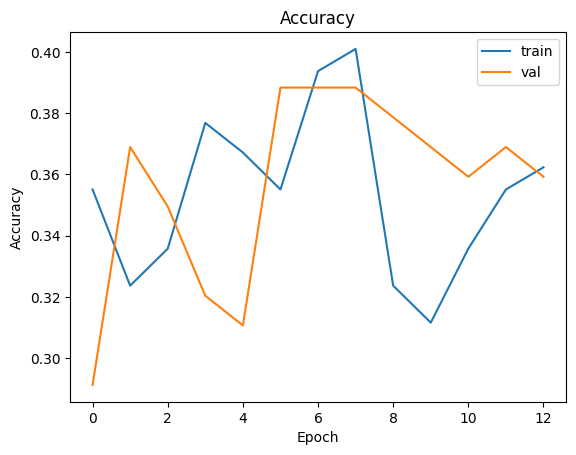

In [9]:
import matplotlib.pyplot as plt

# Merge histories
def merge_hist(h1, h2):
    out = {}
    for k,v in h1.history.items():
        out[k] = v + (h2.history.get(k, []) if h2 else [])
    return out

hist = merge_hist(history1, history2)

plt.figure()
plt.plot(hist['accuracy'], label='train')
plt.plot(hist['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


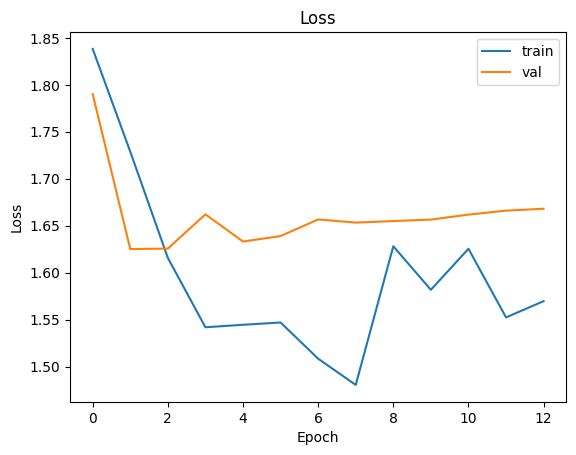

In [10]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(hist['loss'], label='train')
plt.plot(hist['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 7) Confusion matrix on validation set
This helps see which classes are confused by the model.

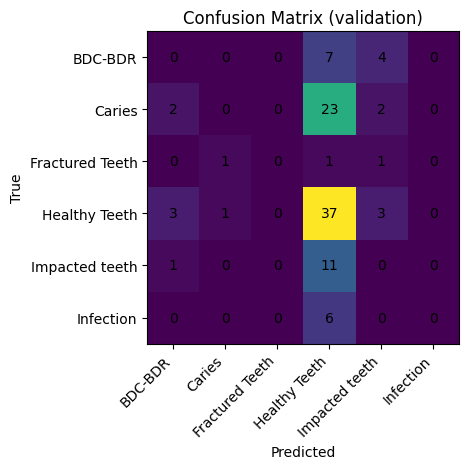

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

y_true=[]; y_pred=[]
for x,y in val_ds:
    p = model.predict(x, verbose=0)
    y_true.append(y.numpy())
    y_pred.append(np.argmax(p, axis=1))
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
cm = confusion_matrix(y_true, y_pred)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cm)
plt.title('Confusion Matrix (validation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j], ha='center', va='center')
plt.tight_layout()
plt.show()


## 8) Grad‑CAM (interpretability)
Visualize which image regions contributed most to the prediction.

In [12]:
import tensorflow as tf, numpy as np, cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_out)[0]
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_out[0]), axis=-1).numpy()
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

# Choose one validation image path manually to visualize
SAMPLE_PATH = None  # e.g., f"{DATA_DIR}/Caries/your_image.jpg"
if SAMPLE_PATH is not None and os.path.exists(SAMPLE_PATH):
    img = image.load_img(SAMPLE_PATH, target_size=IMG_SIZE)
    arr = image.img_to_array(img)/255.0
    arr = np.expand_dims(arr, axis=0)
    cam = gradcam(model, arr, layer_name='Conv_1')  # last conv layer name in MobileNetV2
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (0.4*heatmap + 255*arr[0]).astype(np.uint8)
    plt.figure(); plt.imshow(overlay.astype('uint8')); plt.title('Grad-CAM overlay'); plt.axis('off'); plt.show()
else:
    print('Set SAMPLE_PATH to a real image path to visualize Grad-CAM.')


Set SAMPLE_PATH to a real image path to visualize Grad-CAM.


## 9) Save model
Saves the trained model to your Drive so you can reuse it later.

In [13]:
SAVE_PATH = f"{BASE_DIR}/dental_classifier_mobilenetv2.h5"
model.save(SAVE_PATH)
print('Saved to:', SAVE_PATH)


Saved to: /content/drive/MyDrive/DentalXray-Classifier/dental_classifier_mobilenetv2.h5


### Credits
- Dataset: Dental OPG X-Ray (multi-class) - Kaggle source used : Dental OPG XRAY Dataset (Version 4).
- This notebook is for educational purposes only.
